## Функция распознавания номера (выравнивание + pytesseract)

In [3]:
%%capture
!pip install opencv-python # *not* opencv-contrib-python
!pip install jiwer
!apt install tesseract-ocr
!pip install pytesseract
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

In [2]:
import os
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow

In [4]:
# функции выравнивания
def rotate_image(image, angle):
    (h, w) = image.shape[: 2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags = cv2.INTER_CUBIC, \
        borderMode = cv2.BORDER_REPLICATE)
    return corrected

def determine_score(arr):
     histogram = np.sum(arr, axis = 2, dtype = float)
     score = np.sum((histogram[..., 1 :] - histogram[..., : -1]) ** 2, axis = 1, dtype = float)
     return score

def correct_skew(image, delta = 0.1, limit = 5):
     image = image.astype("uint8")
     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
     thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
     angles = np.arange(-limit, limit + delta, delta)
     img_stack = np.stack([rotate_image(thresh, angle) for angle in angles], axis = 0)
     scores = determine_score(img_stack)
     best_angle = angles[np.argmax(scores)]
     corrected = rotate_image(image, best_angle)
     return best_angle, corrected

In [11]:
# функция распознавания
def recognize_number(im):

  angle, corrected = correct_skew(img)
  res = pytesseract.image_to_string(corrected, lang='eng', config='--psm 8 -c tessedit_char_whitelist=0123456789/- ').replace('\n\x0c', '')
  res = res.strip()

  return res

### Пример работы

In [6]:
# загружаем тестовую картинку
%%capture
!wget https://www.draginda.org/internship_materials/test_area_skewed.jpeg

Исходная картинка:


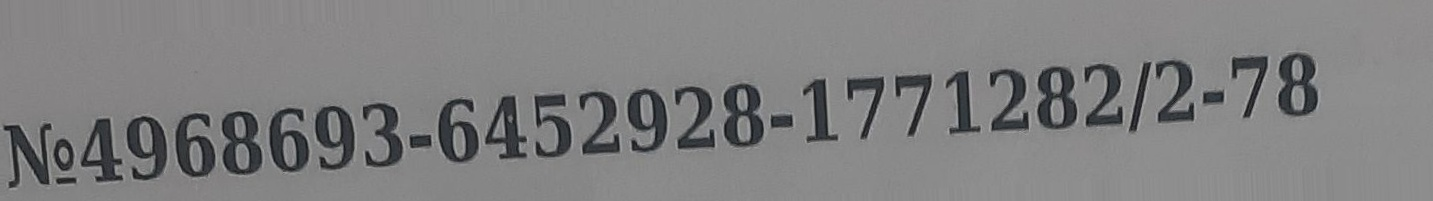

In [12]:
print("Исходная картинка:")
img = cv2.imread('/content/test_area_skewed.jpeg')
cv2_imshow(img)

In [13]:
# результат распознавания
res = recognize_number(img)
print("Результат распознавания:", res)

Результат распознавания: 4968693-6452928-1771282/2-78
